<a href="https://colab.research.google.com/github/NeetishPathak/biz_machine_learning/blob/main/Classifier/Payment_Fraud_Classifier_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Online Payment Fraud Classifier

**Use Case:** It is extremely important for online payment companies to classify the transactions as legitimate or fraudulent for good business and protecing their customers.

**Project Overview**: In this project, we will classify payments as fradulent or non-fradualent using decision tree based machine learning model. 
We need information about online payments to understand what factors can lead to frauds. 

We will use dataset from [Kaggle] (https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset)

Column Reference from dataset

1. step: represents a unit of time where 1 step equals 1 hour
2. type: type of online transaction
3. amount: the amount of the transaction
4. nameOrig: customer starting the transaction
5. oldbalanceOrg: balance before the transaction
6. newbalanceOrig: balance after the transaction
7. nameDest: recipient of the transaction
8. oldbalanceDest: initial balance of recipient before the transaction
9. newbalanceDest: the new balance of recipient after the transaction
10. isFraud: fraud transaction

**Objective**: The model will use the payment features and classify the test data in isFraud class 0 - No Fraud, 1 - Fraud

**Data Source:**
Download the file from this [LINK](https://drive.google.com/uc?export=download&id=1ZTlyuWfspKtOhj7p2uBwHjzfjcIHDfmC) - Full dataset csv filesize is 493MB and has 6.36 million records. Takes longer to load. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import tree
from sklearn import preprocessing

In [2]:
# Loading the online-payments.csv from kaggle dataset - https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset
fileUrl="https://media.githubusercontent.com/media/NeetishPathak/biz_machine_learning/main/Classifier/online-payments.csv"

data = pd.read_csv(fileUrl)

In [3]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
data.shape

(6362620, 11)

## Exploratory Analysis

#### Check NaN values

In [5]:
print('Number of NAN values: {}'.format(data.isna().sum()))
data.dropna(inplace=True) # Dropping NANs

Number of NAN values: step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


#### Categorical Feature Distribution

In [6]:
# Exploring - Categroical Features 

# Type of transactions
print(data.type.value_counts())

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


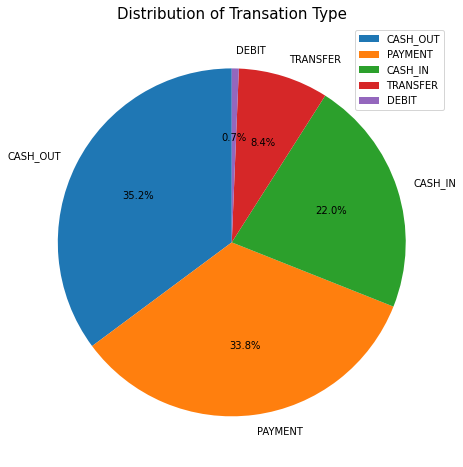

In [7]:
# Let's visualize the a transaction type categorical feature  i.e. distribution of the dataset using a pie chart
type = data["type"].value_counts()
transactions = type.index
quantity = type.values

labels = transactions
sections = quantity

plt.figure(figsize=(8,8))
plt.pie(sections,labels=labels, startangle=90,autopct="%1.1f%%")
plt.title("Distribution of Transation Type",fontsize=15)
plt.legend()
plt.show()

#### Check for skewness in isFraud Class

We will check for the skewness in the data by plotting a barchart. As can be seen below, the dataset is highly skewed towards non-fraud entries. Decision Trees handle skewed classes nicely if we let it grow fully. We will adjust the max-depth.

0    6354407
1       8213
Name: isFraud, dtype: int64


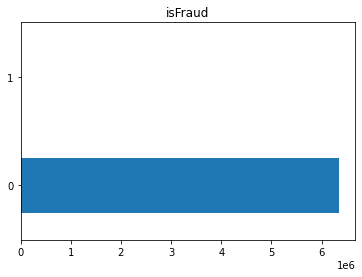

In [8]:
# Visualize the distribution of fraudulent vs non-fraudulent transaction using bar chart
# 0 represents non fradulanet transaction and 1 represents fraudulent transactions
print(data.isFraud.value_counts())
data.isFraud.value_counts().plot(kind='barh', title='isFraud')
plt.show()

## Feature Selection

#### Target Class

In [9]:
y=data.pop('isFraud') # Removing isFraud field and storing it in variable y
y

0          0
1          0
2          1
3          1
4          0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 6362620, dtype: int64

#### Categorical Field and Features Data

In [10]:
categorical_cols = data.columns[data.dtypes=='object'].tolist()
categorical_cols

['type', 'nameOrig', 'nameDest']

In [11]:
categorical_cols = ['type']

In [12]:
features_data = data[['type','amount', 'oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFlaggedFraud']]
features_data

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
0,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0
1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0
2,TRANSFER,181.00,181.00,0.00,0.00,0.00,0
3,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,0
4,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0
...,...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,0
6362616,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,0
6362617,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,0
6362618,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,0


In [13]:
# Create dummy variables
data = pd.get_dummies(data=features_data, columns=categorical_cols, drop_first=False)
data

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.00,160296.36,0.00,0.00,0,0,0,0,1,0
1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0,0,1,0
2,181.00,181.00,0.00,0.00,0.00,0,0,0,0,0,1
3,181.00,181.00,0.00,21182.00,0.00,0,0,1,0,0,0
4,11668.14,41554.00,29885.86,0.00,0.00,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,339682.13,339682.13,0.00,0.00,339682.13,0,0,1,0,0,0
6362616,6311409.28,6311409.28,0.00,0.00,0.00,0,0,0,0,0,1
6362617,6311409.28,6311409.28,0.00,68488.84,6379898.11,0,0,1,0,0,0
6362618,850002.52,850002.52,0.00,0.00,0.00,0,0,0,0,0,1


#### Correlation Matrix

In [14]:
# Let's have a look at the correlation between the features in the data 
t_data=data.copy()
t_data['isFraud']=y
corr = t_data.corr()
print("Correleation Matrix")
corr

Correleation Matrix


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.012295,-0.009621,-0.004376,-0.023379,-0.197444,0.365896,0.076688
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029,0.003835,0.506761,-0.200899,-0.021450,-0.189486,-0.081593,0.010154
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837,0.003776,0.527373,-0.210977,-0.021872,-0.193915,-0.087355,-0.008148
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569,-0.000513,0.076105,0.086028,0.009347,-0.231455,0.130476,-0.005885
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000,-0.000529,0.034988,0.093476,0.006346,-0.238315,0.191701,0.000535
isFlaggedFraud,0.012295,0.003835,0.003776,-0.000513,-0.000529,1.000000,-0.000842,-0.001168,-0.000128,-0.001133,0.005245,0.044109
type_CASH_IN,-0.009621,0.506761,0.527373,0.076105,0.034988,-0.000842,1.000000,-0.391047,-0.042987,-0.379522,-0.160535,-0.019089
type_CASH_OUT,-0.004376,-0.200899,-0.210977,0.086028,0.093476,-0.001168,-0.391047,1.000000,-0.059625,-0.526422,-0.222672,0.011256
type_DEBIT,-0.023379,-0.021450,-0.021872,0.009347,0.006346,-0.000128,-0.042987,-0.059625,1.000000,-0.057868,-0.024478,-0.002911
type_PAYMENT,-0.197444,-0.189486,-0.193915,-0.231455,-0.238315,-0.001133,-0.379522,-0.526422,-0.057868,1.000000,-0.216110,-0.025697


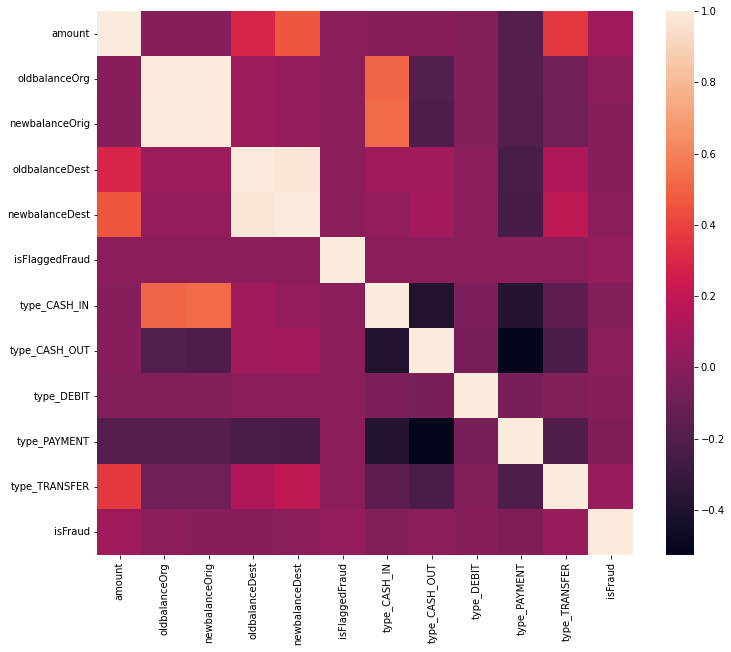

In [15]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr)
plt.show()

In [16]:
cols_to_melt = corr.columns
corr_matrix = corr.reset_index()
corr_matrix_melted = corr_matrix.melt( id_vars='index', value_vars=cols_to_melt)
corr_matrix_melted = corr_matrix_melted[corr_matrix_melted['index'] != corr_matrix_melted['variable']]
corrlations_above_threshold = corr_matrix_melted[corr_matrix_melted.value.abs() > .5]
corrlations_above_threshold

,index,variable,value
14,newbalanceOrig,oldbalanceOrg,0.998803
18,type_CASH_IN,oldbalanceOrg,0.506761
25,oldbalanceOrg,newbalanceOrig,0.998803
30,type_CASH_IN,newbalanceOrig,0.527373
40,newbalanceDest,oldbalanceDest,0.976569
51,oldbalanceDest,newbalanceDest,0.976569
73,oldbalanceOrg,type_CASH_IN,0.506761
74,newbalanceOrig,type_CASH_IN,0.527373
93,type_PAYMENT,type_CASH_OUT,-0.526422
115,type_CASH_OUT,type_PAYMENT,-0.526422


In [17]:
columns_to_drop = corrlations_above_threshold['index'].to_list()
columns_to_drop

['newbalanceOrig',
 'type_CASH_IN',
 'oldbalanceOrg',
 'type_CASH_IN',
 'newbalanceDest',
 'oldbalanceDest',
 'oldbalanceOrg',
 'newbalanceOrig',
 'type_PAYMENT',
 'type_CASH_OUT']

Based on correlation between features , there is strong correletion between following groups. We'll select only one feature from each of the following groups

newbalanceOrig, type_CASH_IN ,oldbalanceOrg

newbalanceDest, oldbalanceDest
 
type_PAYMENT, type_CASH_OUT


Next, we'll observe the correlation with the target variable isFraud

In [18]:
print("Correlation of features with isFraud")
print(corr['isFraud'].sort_values(ascending=False))

Correlation of features with isFraud
isFraud           1.000000
amount            0.076688
type_TRANSFER     0.053869
isFlaggedFraud    0.044109
type_CASH_OUT     0.011256
oldbalanceOrg     0.010154
newbalanceDest    0.000535
type_DEBIT       -0.002911
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
type_CASH_IN     -0.019089
type_PAYMENT     -0.025697
Name: isFraud, dtype: float64



Based on corrletion between the features (should be low) and correlation with target variable (should be high), we will select following features for training the model

`'amount','type_TRANSFER','isFlaggedFraud','newbalanceDest','oldbalanceOrg','type_PAYMENT','type_DEBIT'`


In [19]:
data

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.00,160296.36,0.00,0.00,0,0,0,0,1,0
1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0,0,1,0
2,181.00,181.00,0.00,0.00,0.00,0,0,0,0,0,1
3,181.00,181.00,0.00,21182.00,0.00,0,0,1,0,0,0
4,11668.14,41554.00,29885.86,0.00,0.00,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,339682.13,339682.13,0.00,0.00,339682.13,0,0,1,0,0,0
6362616,6311409.28,6311409.28,0.00,0.00,0.00,0,0,0,0,0,1
6362617,6311409.28,6311409.28,0.00,68488.84,6379898.11,0,0,1,0,0,0
6362618,850002.52,850002.52,0.00,0.00,0.00,0,0,0,0,0,1


#### Final Feature Set

In [20]:
X = data[['amount','type_TRANSFER','isFlaggedFraud','newbalanceDest','oldbalanceOrg','type_PAYMENT','type_DEBIT']]

## Splitting the Data for fraud detection


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25)

In [22]:
X_train.head()

,amount,type_TRANSFER,isFlaggedFraud,newbalanceDest,oldbalanceOrg,type_PAYMENT,type_DEBIT
1763636,13229.60,0,0,0.00,625962.48,1,0
5816400,3133.73,0,0,0.00,128584.40,1,0
2492912,13481.43,0,0,250635.36,3437962.15,0,0
599639,18554.80,0,0,0.00,0.00,1,0
425402,38589.99,0,0,55279.67,11209.00,0,0


## Train the model

### Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth=10)

print(dt_model)

dt_model = dt_model.fit(X_train,y_train)


DecisionTreeClassifier(max_depth=10)


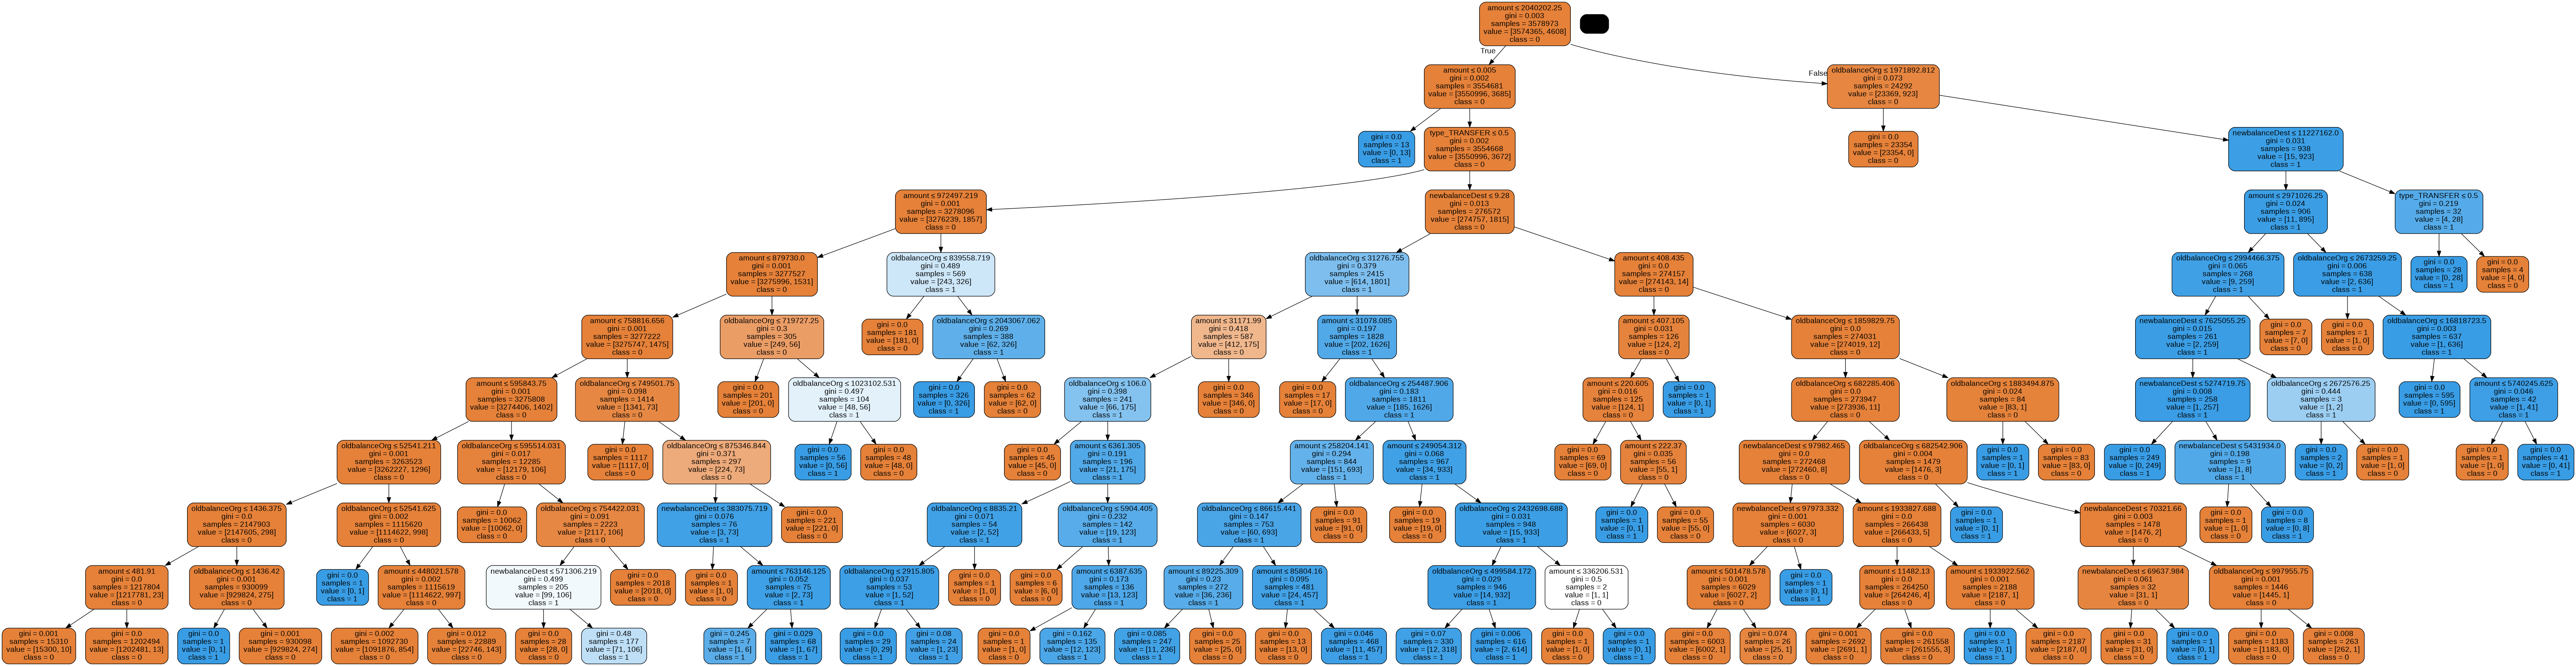

In [24]:
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dt_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X_train.columns.values.tolist(), 
               class_names=['0', '1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Evaluate/Tune The Model

#### Classification report for Validation Data

In [25]:
pred_valid_dt = dt_model.predict_proba(X_valid)[:, 1]

In [26]:
## Validation Set report 
from sklearn.metrics import classification_report
valid_dt_binary = dt_model.predict(X_valid)
print(classification_report(y_valid, valid_dt_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1191450
           1       0.94      0.71      0.81      1542

    accuracy                           1.00   1192992
   macro avg       0.97      0.85      0.90   1192992
weighted avg       1.00      1.00      1.00   1192992




When classifying 'Fraud', 

Precision is proportion transactions predicted fraud were actually fraud.

Recall is the proportion of actual fraud transactions were correctly predicted. It tells proportion of fraudulent transactions that were missed by the model.
In case of online transactions,we want a classifier with higher recall. 

Also, F1 score more than 0.8 is good.

#### ROC Plot for Validation Data

In [27]:
def create_roc_plot(name, predictions, y_val):
  auc = roc_auc_score(y_val, predictions).round(2)
  fpr, tpr, _ = roc_curve(y_val, predictions)

  plt.figure(figsize=(10, 8))
  plt.plot([0, 1], [0, 1], linestyle='--')  # plot horizontal line 
  plt.plot(fpr, tpr, label='{} AUC = {}'.format(name, auc)) # plot the roc curve for the model
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.legend(loc='lower right')  # show the legend
  plt.show() # show the plot
  return None

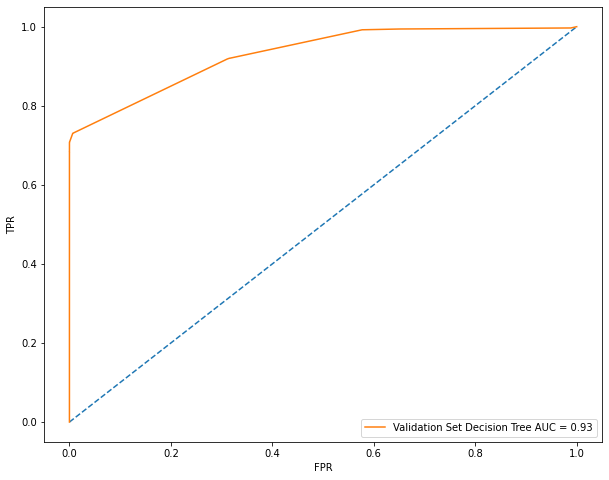

In [28]:
create_roc_plot('Validation Set Decision Tree', pred_valid_dt, y_valid)

**Note:** In this phase, we can try different values of max_depth and see how the score of model is changing. We find that with max_depth=10. We have descent F1 score of 0.8 with recall close to 70%. gini metric of nodes is also close to 0.

## Testing the Model

#### Classification Report for test Data

In [29]:
# Test Set Classification report 
from sklearn.metrics import classification_report
pred_dt_binary = dt_model.predict(X_test)
print(classification_report(y_test, pred_dt_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588592
           1       0.94      0.71      0.81      2063

    accuracy                           1.00   1590655
   macro avg       0.97      0.86      0.91   1590655
weighted avg       1.00      1.00      1.00   1590655



Our Model has 70% recall and 81% f1-score on test data

#### ROC Plot for Test Data

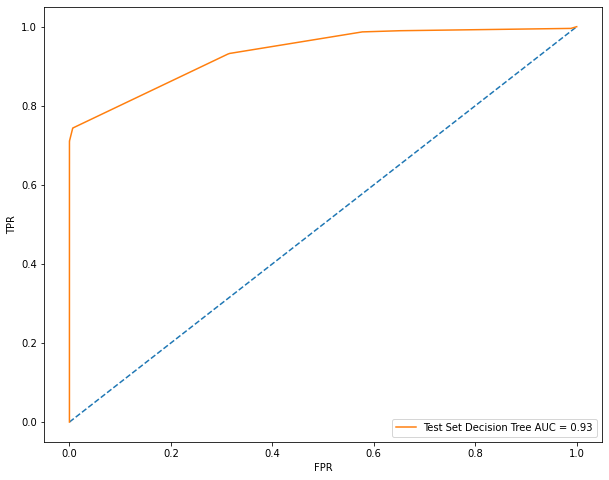

In [30]:
pred_test_dt = dt_model.predict_proba(X_test)[:, 1]
create_roc_plot('Test Set Decision Tree', pred_test_dt, y_test)

#### Visualize Validation and Test Data AUC

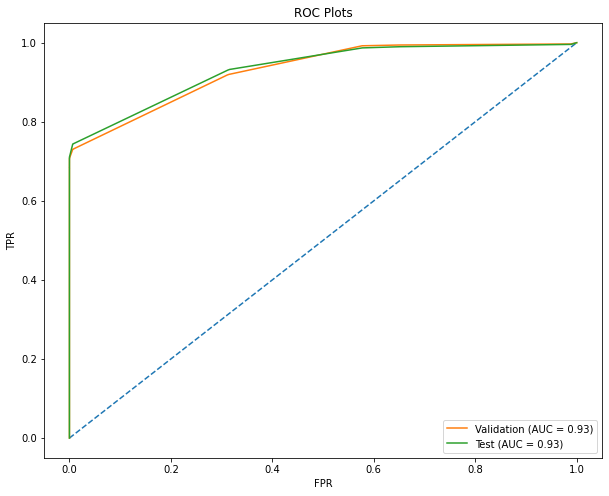

In [31]:
# calculate scores
auc_valid_dt = roc_auc_score(y_valid, pred_valid_dt)
auc_test_dt = roc_auc_score(y_test, pred_test_dt)

# calculate roc curves
fpr_valid_dt, tpr_valid_dt, _ = roc_curve(y_valid, pred_valid_dt)
fpr_test_dt, tpr_test_dt, _ = roc_curve(y_test, pred_test_dt)

plt.figure(figsize=(10, 8))
# plot horizontal line 
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_valid_dt, tpr_valid_dt, label='Validation (AUC = %0.2f)' % auc_valid_dt)
plt.plot(fpr_test_dt, tpr_test_dt, label='Test (AUC = %0.2f)' % auc_test_dt)

# axis labels
plt.xlabel('FPR')
plt.ylabel('TPR')
# show the legend
plt.legend(loc='lower right')
plt.title("ROC Plots")
# show the plot
plt.show()